In [4]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split

import acquire, prepare

np.random.seed(123)

In [5]:
# acquire titanic data
df_titanic = acquire.get_titanic_data()
df_titanic.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,NaN,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,NaN,Southampton,1
3,3,1,1,female,35.0,1,0,53.1000,S,First,C,Southampton,0
4,4,0,3,male,35.0,0,0,8.0500,S,Third,NaN,Southampton,1


In [6]:
# Useful helper for checking for nulls
# What proportion of each column is empty?
df_titanic.isna().mean()

passenger_id    0.000000
survived        0.000000
pclass          0.000000
sex             0.000000
age             0.198653
sibsp           0.000000
parch           0.000000
fare            0.000000
embarked        0.002245
class           0.000000
deck            0.772166
embark_town     0.002245
alone           0.000000
dtype: float64

In [31]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''

    df = df[(df.age.notna()) & (df.embarked.notna())]
    df = df.drop(columns=['deck', 'passenger_id', 'class'])

    dummy_df = pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark'])

    df = pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1)

    df = df.drop(columns=['sex', 'embark_town']) 

    df = df.rename(columns={"sex_female": "is_female"})

    return df

In [33]:
df = prep_titanic(df_titanic)
df.head()

,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,S,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,1,0,0
2,1,3,26.0,0,0,7.9250,S,1,1,0,0,1
3,1,1,35.0,1,0,53.1000,S,0,1,0,0,1
4,0,3,35.0,0,0,8.0500,S,1,0,0,0,1


In [34]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [35]:
# Stratify with categorical target variables
train, validate, test = train_validate_test_split(df, target='survived')
train.shape, validate.shape, test.shape

((398, 12), (171, 12), (143, 12))

### Univariate

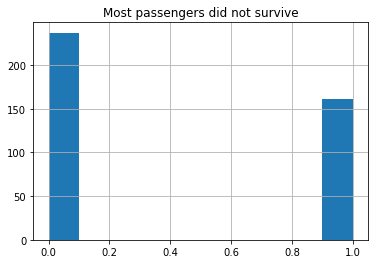

In [36]:
plt.title("Most passengers did not survive")
train.survived.hist()
plt.show()

In [38]:
# We can call .mean() since 0 and 1 are numeric
print('Percent Survived from Train Data')
round(train.survived.mean(), 3)

Percent Survived from Train Data


0.405

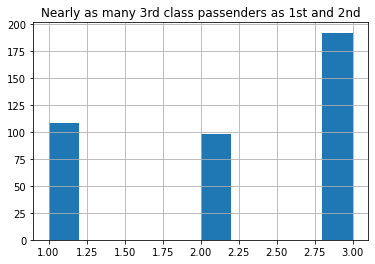

In [39]:
# Plotting 
plt.title('Nearly as many 3rd class passenders as 1st and 2nd')
train.pclass.hist()
plt.show()

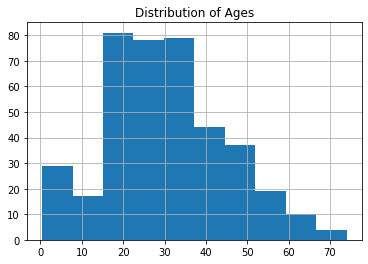

In [40]:
# Plotting Distribution of ages
plt.title('Distribution of Ages')
train.age.hist()
plt.show()

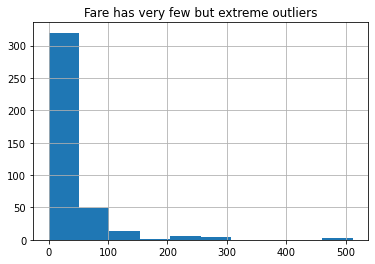

In [41]:
plt.title('Fare has very few but extreme outliers')
train.fare.hist()
plt.show()

### Takeways & Actions
- ~60% perished and ~40% survived. Predicting "not survived" will be our baseline prediction to test the usefulness of features on later when we get to modeling. (With classification, a good baseline is the mode of the target)

- Age seems close enough to a normal distribution

- Fare has some extreme outliers and might still not be normally distributed after removing them. If that's the case, then we would run a Mann-Whitney test instead of a t-test. Use the p-value in the same manner.

- Survived can be treated as either a categorical variable or a number. We can view survived via color on a chart, as categories on the x-axis on a bar chart, or as a proportion between 0 and 1 on the y-axis when viewing another categorical variable to compare "survival rate".

- We can compare proportions of those who survived and those who didn't with another categorical variable. For example, we can test is female passengers were more or less likely to survive than male passengers using a chi-square test.

- We can compare the mean of continuous variables between those who survived to those who did not survive using a test such as a t-test or Mann-Whitney test (the non-parametric version of the t-test). Such as, is there a difference in the average fare paid for those who survived vs. those who did not survive?

In [42]:
train.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,is_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
450,0,2,36.0,1,2,27.75,S,0,0,0,0,1
543,1,2,32.0,1,0,26.00,S,0,0,0,0,1


### Let's Visualize and Test some Categorical Variables to the Target

- pclass to survived. What's the relationship between survival and class of ticket?
- alone to survived. Is traveling with people more helpful for surviving?
- gender to survived. What's the relationship between survival and gender?
- fare to survived. What's the relationship between fare and survival?
- What further combinations of features could you analyze?
- What about binning age into young, middle, and older?
- Are there any features that would make sense to create?

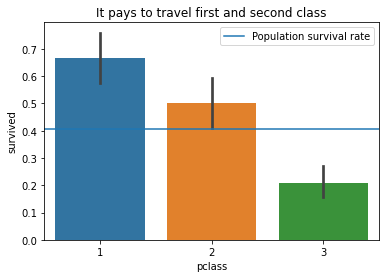

In [43]:
plt.title("It pays to travel first and second class")
sns.barplot(x="pclass", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [44]:
# The above visual is quite clear, but if it was less clear or we want more certainty, we'll run a hypothesis test
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05
null_hypothesis = "survival and class of ticket are independent"
alternative_hypothesis = "there is a relationship between class of ticket and survival"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.pclass)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and class of ticket are independent
Sufficient evidence to move forward understanding that there is a relationship between class of ticket and survival


In [45]:
observed

pclass,1,2,3
survived,,,
0,36,49,152
1,72,49,40


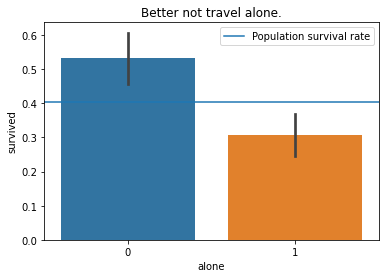

In [46]:
plt.title("Better not travel alone.")
sns.barplot(x="alone", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [47]:
# If the visual was unclear or we need more confirmation, run a hypothesis test
# Let's run a chi squared to compare proportions
alpha = 0.05
null_hypothesis = "survival and traveling alone are independent"
alternative_hypothesis = "there is a relationship between survival and traveling alone"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.alone)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and traveling alone are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and traveling alone


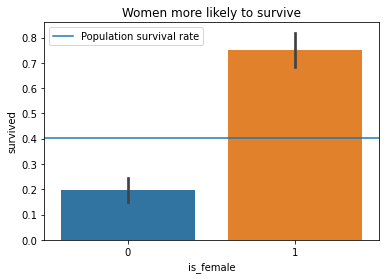

In [48]:
plt.title("Women more likely to survive")
sns.barplot(x="is_female", y="survived", data=train)
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate, label="Population survival rate")
plt.legend()
plt.show()

In [49]:
# Let's run a chi squared to compare proportions, to have more confidence
alpha = 0.05

null_hypothesis = "survival and gender are independent"
alternative_hypothesis = "there is a relationship between survival and gender"

# Setup a crosstab of observed survival to pclass
observed = pd.crosstab(train.survived, train.is_female)

chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("Reject the null hypothesis that", null_hypothesis)
    print("Sufficient evidence to move forward understanding that", alternative_hypothesis)
else:
    print("Fail to reject the null")
    print("Insufficient evidence to reject the null")

Reject the null hypothesis that survival and gender are independent
Sufficient evidence to move forward understanding that there is a relationship between survival and gender


In [50]:
# Subset the data into survived and not-surviving status
not_survived = train[train.survived == 0]
survived = train[train.survived == 1]

In [51]:
# check variances of the two groups
not_survived.fare.var(), survived.fare.var()

(846.4473286218977, 7299.474755819125)

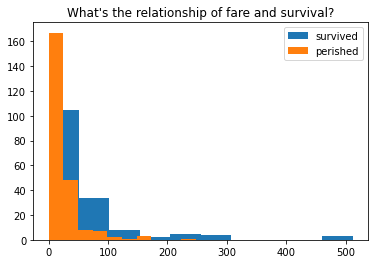

In [52]:
plt.title("What's the relationship of fare and survival?")
plt.hist(survived.fare, label="survived")
plt.hist(not_survived.fare, label="perished")
plt.legend()
plt.show()

In [53]:
from scipy import stats

null_hypothesis = "fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers"
alternative_hypothesis = "fares paid by surviving passengers are higher than non-surviving passengers"

# Use Mann Whitney u-test when t-test assumptions do not hold.
# The distributions are not normal and the variances are not equal, so we'll do mann-whitney
t, p = stats.mannwhitneyu(survived.fare, not_survived.fare, alternative="greater")

In [54]:
if p < alpha:
    print("We find evidence to reject the null hypothesis that", null_hypothesis)
    print("We find evidence evidence to move forward with the understaind that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("There is no evidence that", null_hypothesis)

We find evidence to reject the null hypothesis that fares paid by survived passengers are less than or equal to fares paid by non-surviving passengers
We find evidence evidence to move forward with the understaind that fares paid by surviving passengers are higher than non-surviving passengers


### Takeaways from bivariate exploration, so far

- It pays to travel first and second class
- Better to travel with family/company"
- Women much more likely to survive
- Survivors paid higher fares. This tracks with class of ticket.

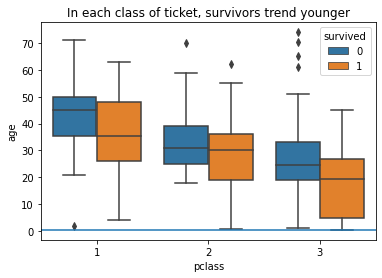

In [55]:
# At each class ticket, women have better survival rates
plt.title("In each class of ticket, survivors trend younger")
sns.boxplot(x="pclass", y="age", data=train, hue="survived")
population_survival_rate = train.survived.mean()
plt.axhline(population_survival_rate)
plt.show()

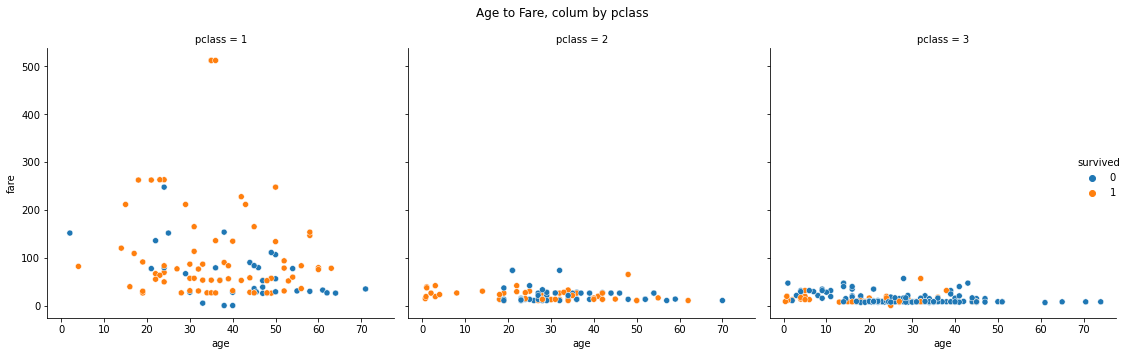

In [56]:
# No discernable relationship between age and fare, but the pclass relates to survival
rel = sns.relplot(x='age', y='fare', data=train, col="pclass", hue="survived")
rel.fig.suptitle('Age to Fare, colum by pclass') # One way to title a relplot
plt.tight_layout()

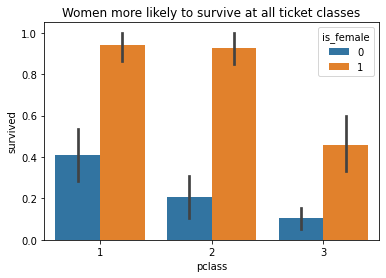

In [57]:
plt.title("Women more likely to survive at all ticket classes")
sns.barplot(x="pclass", y="survived", hue="is_female", data=train)
population_survival_rate = train.survived.mean()
plt.show()

In [58]:
women_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 1)]
men_in_3rd_class = train[(train.pclass == 3) & (train.is_female == 0)]

print(f"Overall survival rate:", round(train.survived.mean(), 2))
print(f"Overall female survival rate", round(train[train.is_female == 1].survived.mean(), 2))
print(f"Overall male survival rate", round(train[train.is_female == 0].survived.mean(), 2))
print(f"3rd class ticket survival rate", round(train[train.pclass == 3].survived.mean(), 2))
print(f"Survival rate for women in 3rd class:", round(women_in_3rd_class.survived.mean(), 2))
print(f"Survival rate for men in 3rd class:", round(men_in_3rd_class.survived.mean(), 2))

Overall survival rate: 0.4
Overall female survival rate 0.75
Overall male survival rate 0.2
3rd class ticket survival rate 0.21
Survival rate for women in 3rd class: 0.46
Survival rate for men in 3rd class: 0.1


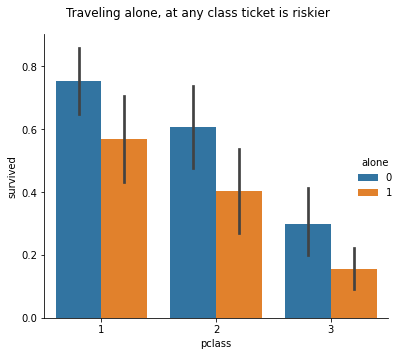

In [59]:
cat = sns.catplot(data=train, x="pclass", y="survived", hue="alone", kind="bar")
cat.fig.suptitle("Traveling alone, at any class ticket is riskier")
plt.tight_layout()

### Takeaways 1. Women more likely to survive at all ticket classes 2. In each class of ticket, survivors trend younger 3. First class alone has better survival than 3rd class traveling with family 4. Fare and age don't seem to correlate, but fare and class of ticket appear related. 5. For both men and women passengers, survival and pclass are dependent

### What do you learn from these? What are some actions you wish to take?

In [60]:
# Gender subset setup
male_subset = train[train.is_female == 0]
female_subset = train[train.is_female == 1]

In [61]:
null_hypothesis = "survival and pclass are independent for female passengers"
alternative_hypothesis = "survival and pclass are dependent for female passengers"

alpha = 0.05
observed = pd.crosstab(female_subset.survived, female_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)

We reject the null hypothesis that survival and pclass are independent for female passengers
Evidence suggests that survival and pclass are dependent for female passengers


In [62]:
null_hypothesis = "survival and pclass are independent for male passengers"
alternative_hypothesis = "survival and pclass are dependent for male passengers"

alpha = 0.05
observed = pd.crosstab(male_subset.survived, male_subset.pclass)
chi2, p, degf, expected = stats.chi2_contingency(observed)

if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("Evidence suggests that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    print("We find insufficient evidence to support the claim that", alternative_hypothesis)

We reject the null hypothesis that survival and pclass are independent for male passengers
Evidence suggests that survival and pclass are dependent for male passengers
